In [ ]:
import pathlib
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import seaborn as sns
import torch
import torchvision.transforms as T
import tqdm
from sklearn.metrics import accuracy_score, auc, precision_recall_curve, roc_curve
from torchmetrics.classification import BinaryROC

from src.data.dataset import BGRArtifcatDataset
from src.model.modules import UNetDetectionModule

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
TEST_DIR = pathlib.Path("data") / "detect" / "test"
FLARE_REAL_TEST_DIR = TEST_DIR / "real"
FLARE_SYNTH_TEST_DIR = TEST_DIR / "synth"
MASKED_TEST_DIR = TEST_DIR / "masked"

masked_test_paths = sorted(MASKED_TEST_DIR.glob("*.npy"))
synth_test_paths = sorted(FLARE_SYNTH_TEST_DIR.glob("*.npy"))
real_test_paths = sorted(FLARE_REAL_TEST_DIR.glob("*.npy"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

len(masked_test_paths), len(synth_test_paths), len(real_test_paths)

(53, 100, 100)

In [ ]:
masked_dataset = BGRArtifcatDataset(
    masked_test_paths,
    augmenter=None,
    transform=T.Compose(
        [
            T.ToTensor(),
        ]
    ),
    test_mode=True,
)
synth_dataset = BGRArtifcatDataset(
    synth_test_paths,
    augmenter=None,
    transform=T.Compose(
        [
            T.ToTensor(),
        ]
    ),
    test_mode=True,
)
real_dataset = BGRArtifcatDataset(
    real_test_paths,
    augmenter=None,
    transform=T.Compose(
        [
            T.ToTensor(),
        ]
    ),
    test_mode=True,
)

masked_dataloader = torch.utils.data.DataLoader(
    masked_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)
synth_dataloader = torch.utils.data.DataLoader(
    synth_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)
real_dataloader = torch.utils.data.DataLoader(
    real_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [ ]:
det_model = UNetDetectionModule(
    n_blocks=4,
    kernel_size=3,
    block_depth=5,
    with_fft=False,
    in_channels=3,
).to("cuda")

det_model.load_state_dict(
    torch.load("pretrained/target_models/ad-edp317.pth", weights_only=True)[
        "state_dict"
    ]
)
...

Ellipsis

In [ ]:
masked_preds = []
for x, y in tqdm.tqdm(masked_dataloader, desc="Masked"):
    with torch.no_grad():
        pred = det_model(x.to(device))
    pred = (pred.cpu().permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
    masked_preds.append(pred[0])

synth_preds = []
for x, y in tqdm.tqdm(synth_dataloader, desc="Synth"):
    with torch.no_grad():
        pred = det_model(x.to(device))
    pred = (pred.cpu().permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
    synth_preds.append(pred[0])

real_preds = []
for x, y in tqdm.tqdm(real_dataloader, desc="Real"):
    with torch.no_grad():
        pred = det_model(x.to(device))
    pred = (pred.cpu().permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
    real_preds.append(pred[0])

Real: 100%|██████████| 100/100 [08:39<00:00,  5.19s/it]


In [ ]:
masked_expected = [np.load(path)[..., 3] for path in masked_test_paths]
synth_expected = [np.load(path)[..., 3] for path in synth_test_paths]
real_expected = [np.load(path)[..., 3] for path in real_test_paths]


all_cfgs = [
    (masked_preds, masked_expected, "Masked"),
    (synth_preds, synth_expected, "Synth"),
    (real_preds, real_expected, "Real"),
]
with open("cfgs.pkl", "wb") as f:
    pickle.dump(all_cfgs, f)

In [ ]:
with open("cfgs.pkl", mode="rb") as f:
    all_cfgs = pickle.load(f)

In [ ]:
OFFSET = -58


def sun_10_rename(p_stem: str) -> str:
    if not p_stem.startswith("sun10"):
        return p_stem

In [ ]:
debug_frames = sorted(
    (pathlib.Path("data") / "excluded" / "_ALL_UNPACKED").glob("*.png")
)
debug_stems = {path.stem for path in debug_frames}
debug_stems = {p for p in debug_stems}

all_npy = set(p.stem for p in pathlib.Path("data").glob("**/*.npy"))
debug_stems - all_npy

{'sun10_0001',
 'sun10_0149',
 'sun10_0244',
 'sun10_0343',
 'sun10_0420',
 'sun10_0547',
 'sun10_0579',
 'sun10_0624',
 'sun10_0661',
 'sun10_0670',
 'sun10_0690',
 'sun10_0767',
 'sun10_0847',
 'sun10_1021',
 'sun10_1657',
 'sun10_1738'}

In [ ]:
def evaluate_masks(ground_truth_masks, prediction_masks):
    """
    Evaluates binary masks against soft prediction masks.

    Args:
        ground_truth_masks: List of binary masks (0 or 255)
        prediction_masks: List of soft prediction masks (0-255)

    Returns:
        Dictionary with evaluation metrics
    """
    # Convert masks to appropriate format
    gt_flat = []
    pred_flat = []

    for gt_mask, pred_mask in zip(ground_truth_masks, prediction_masks):
        # Flatten and normalize
        gt_flat.extend((gt_mask / 255).flatten())
        pred_flat.extend((pred_mask / 255).flatten())

    # Convert to torch tensors
    gt_tensor = torch.tensor(gt_flat, dtype=torch.int)
    pred_tensor = torch.tensor(pred_flat, dtype=torch.float)

    roc = BinaryROC()
    roc(pred_tensor, gt_tensor)

    # Convert to numpy for sklearn metrics
    gt_np = np.array(gt_flat)
    pred_np = np.array(pred_flat)

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(gt_np, pred_np)
    pr_auc = auc(recall, precision)  # Calculate PR AUC using sklearn

    # Calculate ROC curve
    fpr, tpr, roc_thresholds = roc_curve(gt_np, pred_np)
    roc_auc = auc(fpr, tpr)  # Calculate ROC AUC using sklearn

    # Find optimal threshold based on maximizing accuracy
    accuracies = []
    for threshold in thresholds:
        pred_binary = (pred_np >= threshold).astype(int)
        accuracies.append(accuracy_score(gt_np, pred_binary))

    optimal_idx = np.argmax(accuracies)
    optimal_threshold = thresholds[optimal_idx]

    # Calculate metrics at optimal threshold
    pred_binary = (pred_np >= optimal_threshold).astype(int)
    optimal_accuracy = accuracy_score(gt_np, pred_binary)

    # Calculate precision and recall at optimal threshold
    true_positives = np.sum((pred_binary == 1) & (gt_np == 1))
    false_positives = np.sum((pred_binary == 1) & (gt_np == 0))
    false_negatives = np.sum((pred_binary == 0) & (gt_np == 1))

    optimal_precision = (
        true_positives / (true_positives + false_positives)
        if (true_positives + false_positives) > 0
        else 0
    )
    optimal_recall = (
        true_positives / (true_positives + false_negatives)
        if (true_positives + false_negatives) > 0
        else 0
    )

    # Prepare results dictionary
    results = {
        "roc": roc,
        "pr_auc": float(pr_auc),
        "roc_auc": float(roc_auc),
        "optimal_threshold": float(optimal_threshold),
        "optimal_accuracy": float(optimal_accuracy),
        "optimal_precision": float(optimal_precision),
        "optimal_recall": float(optimal_recall),
    }

    return results

In [ ]:
results = []
for cfg in all_cfgs:
    preds, expected, name = cfg
    print(f"Evaluating {name} dataset")
    metrics = evaluate_masks(expected, preds)
    metrics["dataset"] = name
    results.append(metrics)

results_df = pd.DataFrame(results)

Evaluating Masked dataset
Evaluating Synth dataset
Evaluating Real dataset


In [ ]:
results_df.to_csv("cfgs_results.csv", index=False)

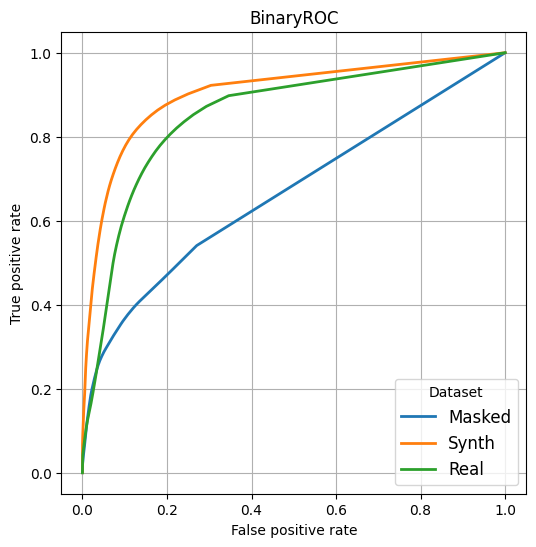

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for r in results:
    r["roc"].plot(ax=ax)
ax.legend(["Masked", "Synth", "Real"], loc="lower right", fontsize=12, title="Dataset")
plt.show()

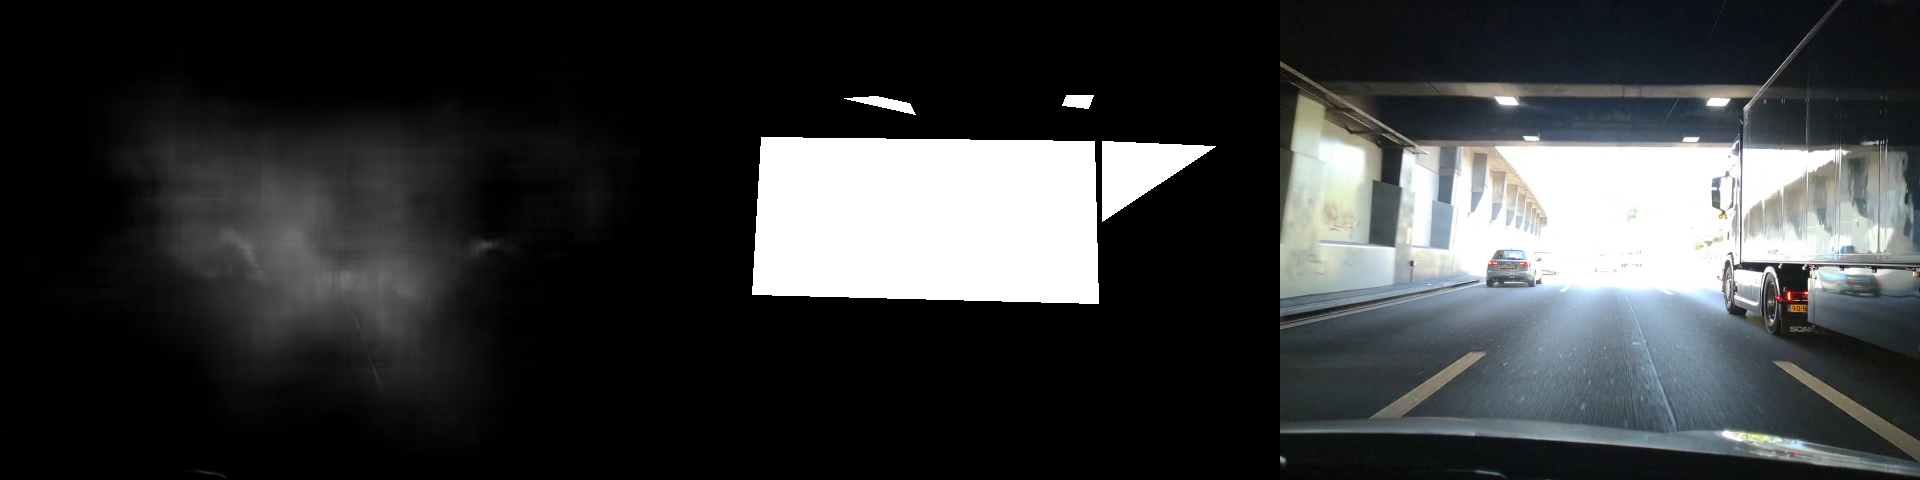

In [ ]:
idx = 22
pred = masked_preds[idx]
pred = np.repeat(pred, 3, axis=-1)
expected = masked_expected[idx][..., np.newaxis]
expected = np.repeat(expected, 3, axis=-1)
orig = np.load(masked_test_paths[idx])[..., :3]
concat = np.concatenate([pred, expected, orig], axis=1)
showarray(concat)

In [ ]:
results_df.round(3)

,roc,pr_auc,roc_auc,optimal_threshold,optimal_accuracy,optimal_precision,optimal_recall,dataset
0,BinaryROC(),0.346,0.666,0.196,0.876,0.596,0.173,Masked
1,BinaryROC(),0.793,0.903,0.071,0.875,0.764,0.697,Synth
2,BinaryROC(),0.712,0.852,0.063,0.815,0.709,0.673,Real


15407

{'sun10_0001',
 'sun10_0149',
 'sun10_0244',
 'sun10_0343',
 'sun10_0420',
 'sun10_0547',
 'sun10_0579',
 'sun10_0624',
 'sun10_0661',
 'sun10_0670',
 'sun10_0690',
 'sun10_0767',
 'sun10_0847',
 'sun10_1021',
 'sun10_1657',
 'sun10_1738'}